## Gradient based CTCF motif 

### test data adopted from https://github.com/p-koo/deepomics.git

In [1]:
import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import logomaker as lm
import pandas as pd


# load CTCF dataset

Here, we will employ a CNN model to experimental ChIP-seq data for CTCF, a transciption factor that is known to bind to DNA and help form loops. 
CTCF conservative narrow peaks were downloaded from the ENCODE database:
https://www.encodeproject.org/experiments/ENCSR000BIE/

!wget https://www.encodeproject.org/files/ENCFF252PLM/@@download/ENCFF252PLM.bed.gz

The peaks were processed with a script (process_chip.py), whose steps include:
    1. enforce a constant window about each peak (window size = 100 nts)
    2. employ bedtools to extract sequences from GRC38 reference genome
    3. filter sequences which contain `N' characters
    4. convert sequences into a one-hot representation
    5. generate background sequences by performing a dinucleotide shuffle using meme
    6. combine and shuffles positive and negative sequences
    7. create a label vector with either a one for sequences that has a ChIP-seq peak and a zero for di-nuc shuffled sequences
    8. split the dataset into a training set, validation set, and test set
    9. save dataset to a hdf5 file
    
After processing, this dataset includes 72,769 training sequences, 10,396 validation sequences, and 20,792 test sequences.  Each sequence is 100 nts long taken about the center of a CHIP-seq peak  called across two replicates. The positive sequences have a label of 1, while the background sequences have a label of 0 (Y_train).  

Note that the training sequences (X_train) have a shape of [72769, 4, 200].  Although tensorflow supports a 1D convolution function, tensorflow was designed with 2D images in mind, so there is way better support for the 2D functions.  We can use these 2D functions by adding another 'ornamental' dimension.  

In [2]:
def draw_logo_saliency(saliency, max = None, start=None, end=None):
    index_word = {0:"A",
       1:"C",
       2:"G",
       3:"T"}

    saliency_df = pd.DataFrame(np.array(saliency))

    saliency_df = saliency_df.rename(columns=index_word)

    if max:
      max_saliency_df = saliency_df.max(axis=1)
      for index in range(len(saliency_df)):
          for i,n in enumerate(saliency_df.iloc[index]):
              if n != max_saliency_df[index]:
                  saliency_df.iloc[index][i] = 0

    logo = lm.Logo(saliency_df, font_name='Hobo Std', figsize=(20,4))
    # plt.xticks(np.arange(len(original_sequence)), list(original_sequence))
    plt.title("LOGO Saliency")
    plt.legend()

In [3]:
# path to dataset 
data_file_path = '/home/stark/PycharmProjects/pkoo/tensorflow_tutorial_genomics-master/data/CTCF_100.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = X_train.transpose([0, 2, 1])
X_test = X_test.transpose([0, 2, 1])
X_valid = X_valid.transpose([0, 2, 1])


# Note: deepomics takes as input a dictionary for each dataset
train = {'inputs': X_train, 'targets': Y_train}
valid = {'inputs': X_valid, 'targets': Y_valid}
test = {'inputs': X_test, 'targets': Y_test}

In [4]:
a = train["inputs"]
b = train["targets"]
a.shape, b.shape

((72769, 100, 4), (72769, 1))

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, InputLayer, BatchNormalization, MaxPooling1D, Dropout, Flatten, LayerNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [6]:
def cnn_model(max_len, vocab_size, batch_size):
    model = Sequential([
        InputLayer(input_shape=(max_len,vocab_size)),
        Conv1D(filters=64, kernel_size=19, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=5),
        Dropout(0.8),
        Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=3),
        Dropout(0.8),
        # Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'),
        # BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        # Conv1D(filters=256, kernel_size=3, padding='valid', activation='relu'),
        # BatchNormalization(),
        # MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [7]:
model = cnn_model(max_len=100, vocab_size=4, batch_size=100)
model.summary()
model.compile(optimizer="Adam", 
              loss=tf.keras.metrics.binary_crossentropy, 
              metrics=["Accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.AUC(curve="PR")])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 82, 64)            4928      
                                                                 
 batch_normalization (BatchN  (None, 82, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           57472     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 128)          5

2022-01-14 14:02:09.697140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-14 14:02:10.092270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22009 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:42:00.0, compute capability: 8.6


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(x=X_train, y=Y_train, batch_size=100, epochs=50, verbose='auto', validation_data=(X_valid, Y_valid), callbacks=[early_stopping])

Epoch 1/50


2022-01-14 14:02:12.871831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2022-01-14 14:02:14.001667: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-01-14 14:02:14.003811: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-01-14 14:02:14.003862: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-01-14 14:02:14.004052: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

728/728 [==============================] - 13s 12ms/step - loss: 0.7633 - Accuracy: 0.5014 - auc: 0.5017 - auc_1: 0.5007 - val_loss: 0.6932 - val_Accuracy: 0.4944 - val_auc: 0.5158 - val_auc_1: 0.5215
Epoch 2/50
728/728 [==============================] - 8s 11ms/step - loss: 0.6948 - Accuracy: 0.5029 - auc: 0.5029 - auc_1: 0.5024 - val_loss: 0.6946 - val_Accuracy: 0.4944 - val_auc: 0.5390 - val_auc_1: 0.5351
Epoch 3/50
728/728 [==============================] - 8s 11ms/step - loss: 0.6733 - Accuracy: 0.5611 - auc: 0.5957 - auc_1: 0.6083 - val_loss: 0.8017 - val_Accuracy: 0.4947 - val_auc: 0.7563 - val_auc_1: 0.8050
Epoch 4/50
728/728 [==============================] - 8s 11ms/step - loss: 0.4721 - Accuracy: 0.7841 - auc: 0.8527 - auc_1: 0.8690 - val_loss: 0.7137 - val_Accuracy: 0.6579 - val_auc: 0.9439 - val_auc_1: 0.9542
Epoch 5/50
728/728 [==============================] - 8s 11ms/step - loss: 0.3844 - Accuracy: 0.8469 - auc: 0.9021 - auc_1: 0.9146 - val_loss: 0.6334 - val_Accuracy: 

In [9]:
predicted_label = model.predict(X_test)
auc = tf.keras.metrics.AUC(num_thresholds=200,curve='ROC')
pr_auc = tf.keras.metrics.AUC(num_thresholds=200, curve='PR')

In [10]:
auc.update_state(Y_test, predicted_label)
pr_auc.update_state(Y_test, predicted_label)
print("AUC: ", auc.result().numpy())
print("PR_AUC: ", pr_auc.result().numpy())

AUC:  0.96857417
PR_AUC:  0.9735791


In [11]:
def calculate_saliency(seq, true_label, model):
    seq = np.array([seq])
    seq = tf.Variable(seq, dtype=float)

    with tf.GradientTape(persistent=True) as tape:
        pred = model(seq, training=False)
        cce = tf.keras.losses.BinaryCrossentropy()
        loss = cce(true_label, pred[0])
        loss = tf.convert_to_tensor(loss)

    # backpropogate to find gradients
    print(pred)
    gradients = tape.gradient(pred, seq)
    # positive or negative gradients are all region change "dramatically"

    # grad_abs = tf.math.abs(gradients)

    grad_abs = tf.math.maximum(gradients,0)

    # grad_abs = tf.math.minimum(gradients,0)
    # grad_abs = tf.math.abs(grad_abs)

    # normalize gradients to range between 0 and 1
    grad_min, grad_max  = np.min(grad_abs), np.max(grad_abs)
    # grad_norm = (grad_abs - grad_min) / (grad_max - grad_min + 1e-18)
    grad_norm = grad_abs/grad_max
    saliency = grad_norm[0]

    # norm = np.outer(np.ones(saliency.shape[0]), np.sum(np.abs(saliency), axis=0))

    return saliency

tf.Tensor([[0.9740916]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


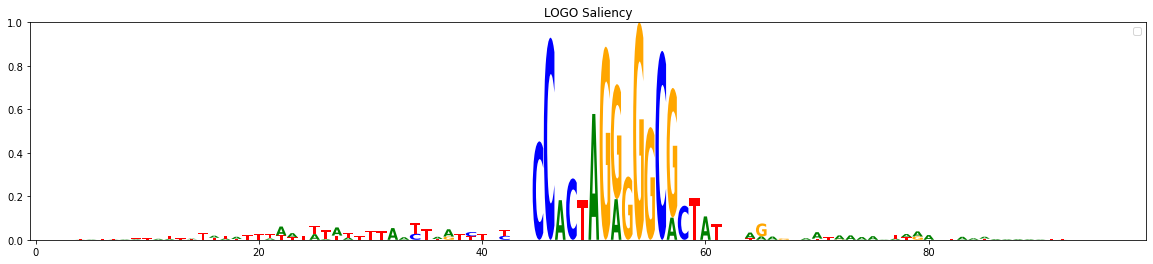

In [22]:
idx = 13514
seq = X_test[idx]
true_label = Y_test[idx]
seq = np.array([seq])
seq = tf.Variable(seq, dtype=float)
with tf.GradientTape(persistent=True) as tape:
        pred = model(seq, training=False)
        cce = tf.keras.losses.BinaryCrossentropy()
        loss = cce(true_label, pred[0])
        loss = tf.convert_to_tensor(loss)

# backpropogate to find gradients
gradients = tape.gradient(pred, seq)
print(pred)
# positive or negative gradients are all region change "dramatically"

# grad_abs = tf.math.abs(gradients)

grad_abs = tf.math.maximum(gradients,0)

# grad_abs = tf.math.minimum(gradients,0)
# grad_abs = tf.math.abs(grad_abs)

# normalize gradients to range between 0 and 1
grad_min, grad_max  = np.min(grad_abs), np.max(grad_abs)
# grad_norm = (grad_abs - grad_min) / (grad_max - grad_min + 1e-18)
grad_norm = grad_abs/grad_max
saliency = grad_norm[0]

draw_logo_saliency(saliency)

tf.Tensor([[0.864043]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


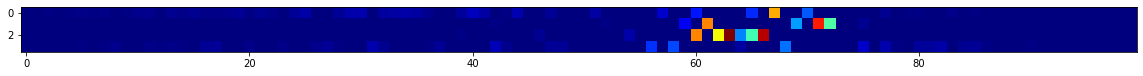

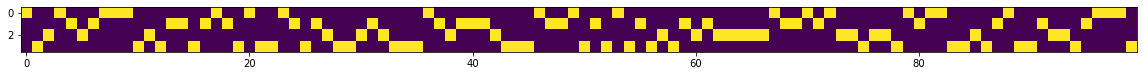

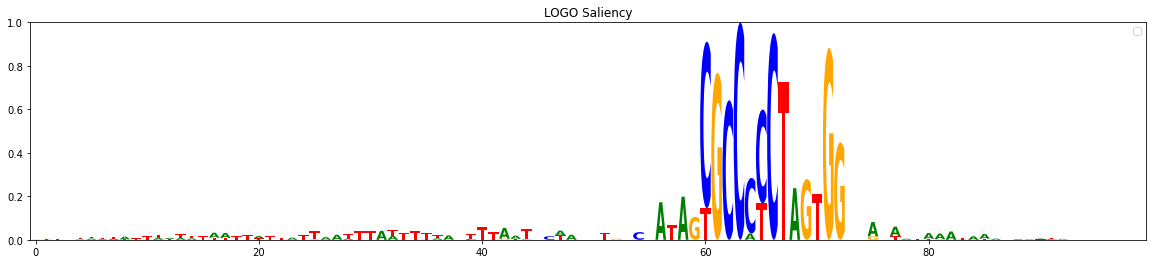

In [14]:
idx = 14808
sal = calculate_saliency(X_test[idx], Y_test[idx], model)
plt.figure(0, figsize=(20,12))
plt.imshow(np.rot90(sal), cmap='jet')
plt.figure(1, figsize=(20,12))
plt.imshow(np.rot90(X_test[idx]))
draw_logo_saliency(sal)

tf.Tensor([[0.9623859]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


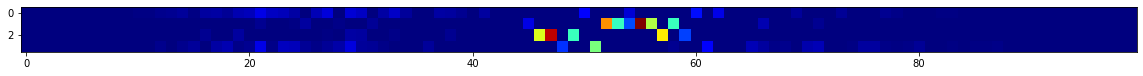

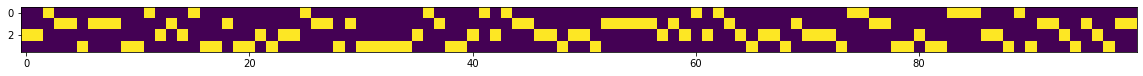

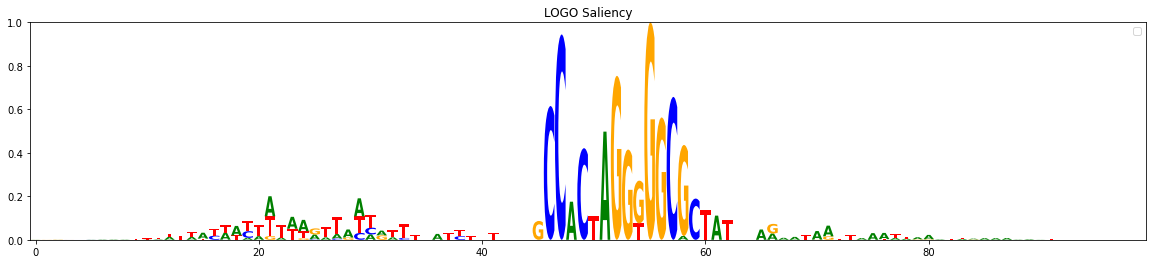

In [15]:
idx = 15914
sal = calculate_saliency(X_test[idx], Y_test[idx], model)
plt.figure(0, figsize=(20,12))
plt.imshow(np.rot90(sal), cmap='jet')
plt.figure(1, figsize=(20,12))
plt.imshow(np.rot90(X_test[idx]))
draw_logo_saliency(sal)

In [16]:
predicted_label = model.predict(X_test)
plot_index = np.argsort(predicted_label[:,0])[::-1]

tf.Tensor([[0.9789834]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


tf.Tensor([[0.9771936]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


tf.Tensor([[0.97544175]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


tf.Tensor([[0.9740916]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


tf.Tensor([[0.97367847]], shape=(1, 1), dtype=float32)


No handles with labels found to put in legend.


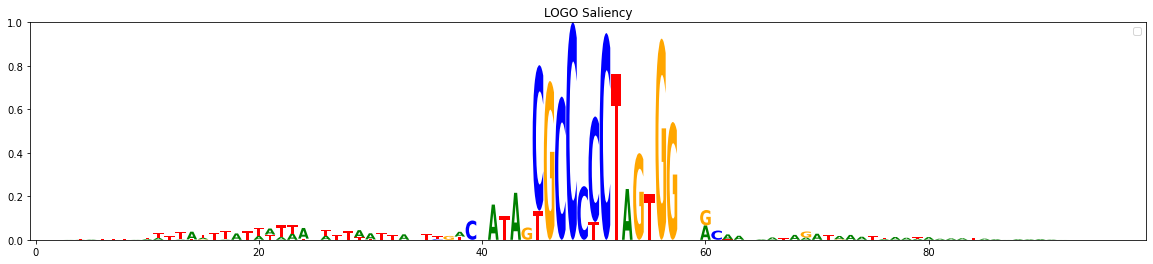

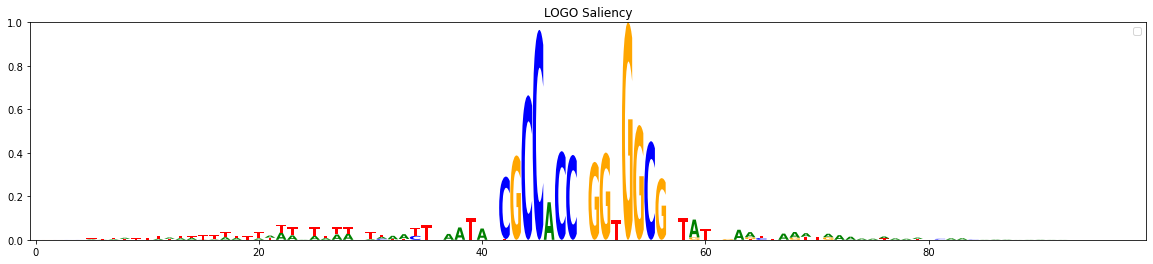

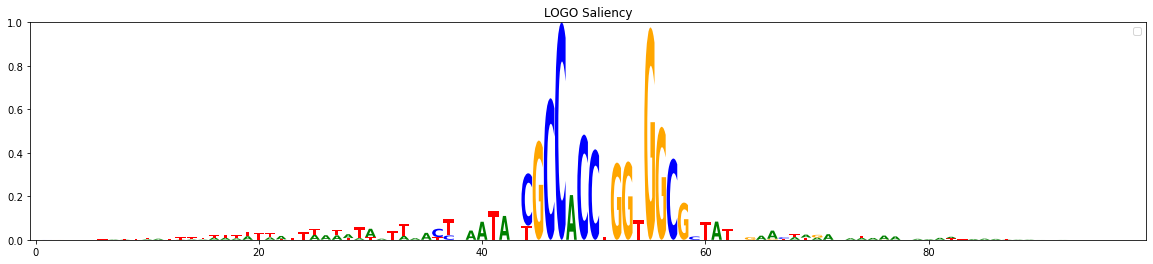

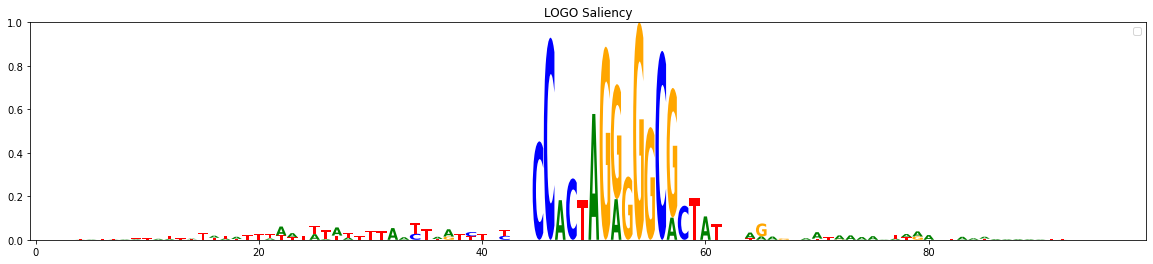

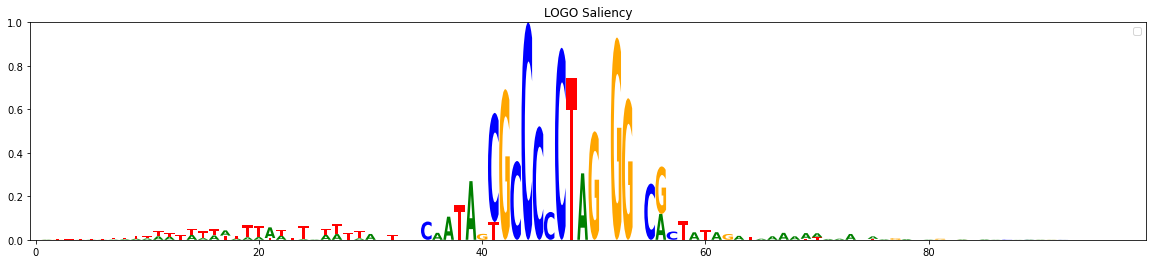

In [17]:
for i in plot_index[:5]:
  sal = calculate_saliency(X_test[i], Y_test[i], model)
  draw_logo_saliency(sal)